# Full Vector vs Sliding Window Decoder Delay 

The purpose of this notebook is to demonstrate the ``SlidingWindowDecoder``'s decreased decoding delay, compared to the block based ``FullVectorDecoder``.

The decreased decoding delay is useful in certain use cases where latency is crucial.

By using the ``full_vector_vs_sliding_window.benchmark`` we can collect the needed data. Lets first look at the code for the data collection (we use the ``inspect`` module to get the benchmark code):

In [1]:
import full_vector_vs_sliding_window
import inspect
print("".join(inspect.getsourcelines(full_vector_vs_sliding_window.benchmark)[0]))


def benchmark(encoder, decoder, channel_condition):
    """Full vector vs sliding window benchmark."""
    # Create some data to encode. In this case we make a buffer
    # with the same size as the encoder's block size (the max.
    # amount a single encoder can encode)
    # Just for fun - fill the input data with random data
    data_in = os.urandom(encoder.block_size())

    # Let's split the data into symbols and feed the encoder one symbol at a
    # time
    symbol_storage = [
        data_in[i:i + encoder.symbol_size()]
        for i in range(0, len(data_in), encoder.symbol_size())
    ]

    results = {}
    ticks = 0
    while not decoder.is_complete():
        ticks += 1
        rank = encoder.rank()
        if rank < encoder.symbols():
            encoder.set_const_symbol(rank, symbol_storage[rank])

        # Check if we can start the transmission before having all the data.
        # if not hasattr(encoder, 'read_feedback') and \
        #    rank != encoder.symbols():
  

Using this function we simply need to provide it with an encoder, decoder and channel condition. This is done for both codecs.

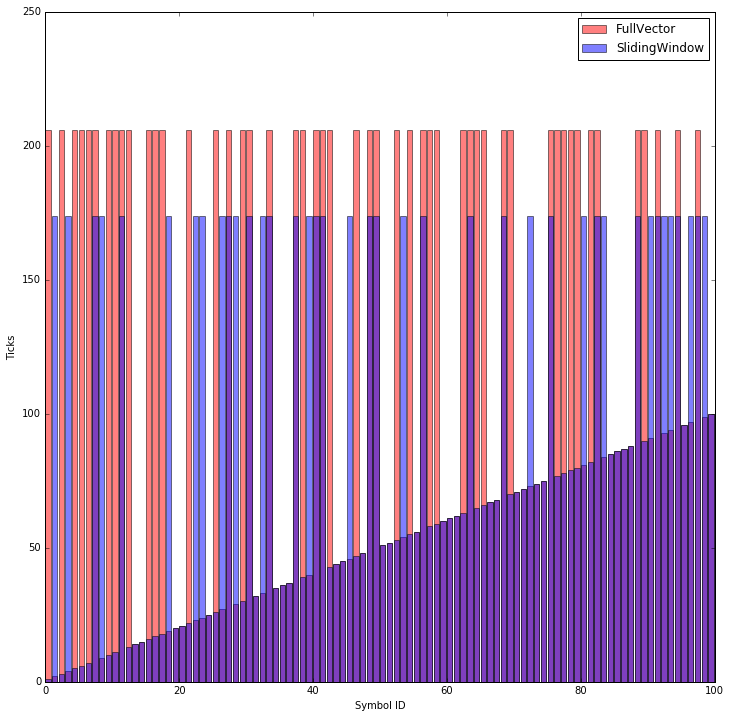

In [2]:
import kodo
import full_vector_vs_sliding_window

symbols = 100
symbol_size = 250

# In the following we will make an encoder/decoder factory.
# The factories are used to build actual encoders/decoders
sliding_window_encoder_factory = kodo.SlidingWindowEncoderFactoryBinary8(
    max_symbols=symbols,
    max_symbol_size=symbol_size)

sliding_window_encoder = sliding_window_encoder_factory.build()

sliding_window_decoder_factory = kodo.SlidingWindowDecoderFactoryBinary8(
    max_symbols=symbols,
    max_symbol_size=symbol_size)

sliding_window_decoder = sliding_window_decoder_factory.build()

full_vector_encoder_factory = kodo.FullVectorEncoderFactoryBinary8(
    max_symbols=symbols,
    max_symbol_size=symbol_size)

full_vector_encoder = full_vector_encoder_factory.build()

full_vector_decoder_factory = kodo.FullVectorDecoderFactoryBinary8(
    max_symbols=symbols,
    max_symbol_size=symbol_size)

full_vector_decoder = full_vector_decoder_factory.build()

# Set the channel condition
channel_condition = 0.5

full_vector_results = full_vector_vs_sliding_window.benchmark(
    full_vector_encoder, full_vector_decoder, channel_condition)

sliding_window_results = full_vector_vs_sliding_window.benchmark(
    sliding_window_encoder, sliding_window_decoder, channel_condition)

%matplotlib inline
import numpy as np
import matplotlib

from matplotlib import pyplot as plt

plt.figure(figsize=(12, 12))

plt.xlabel('Symbol ID')
plt.ylabel('Ticks')

plt.bar(
    full_vector_results.keys(),
    full_vector_results.values(),
    color='red',
    alpha=0.5,
    label="FullVector")

plt.bar(
    sliding_window_results.keys(),
    sliding_window_results.values(),
    color='blue',
    alpha=0.5,
    label="SlidingWindow")

plt.legend(loc='best')
pass